In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import pyross
import numpy as np
import matplotlib.pyplot as plt

# Introduction: Forecast for SEAI5R model with stochastic parameters

In this notebook, we consider the SEAI5R model. 

We assume that the parameters 

* $\alpha$ (fraction of asymptomatic infectives),
* $\beta$ (probability of infection on contact),
* $\gamma_{E}$ (rate of progression for exposed individual to class A), 
* $\gamma_{A}$ (rate of progression from class A to infective class), 
* $\gamma_{I_a}$ (rate of progression for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of progression for symptomatic infected individuals) 

are not known exactly, but rather are characterized by a 6D Gaussian distribution with known mean and covariance matrix. The Gaussian distribution function is truncated, i.e. set to zero if any parameter is $< 0$.

**We now illustrate how uncertainties in the parameters affect the predictions of the SEAI5R model.**

For this we simulate the SEAI5R model $N_s = 500$ times; for each simulation the above parameters are sampled from a given 6D Gaussian distribution. The resulting 500 trajectories are shown together with their mean, standard deviation, median, and 5 as well as 95 percentiles.

We perform this analysis for the deterministic SEAI5R model.

**Note that while this example uses the UK age structure and contact matrix, the model parameters are not fitted to any real data, but chosen ad-hoc.**

# Define model parameters and initialise pyross.forecast.SEAIRQ

In [3]:
M=16  # number of age groups

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

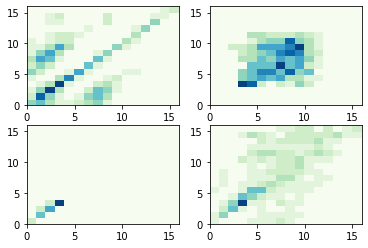

In [4]:
# contact matrices
CH, CW, CS, CO = pyross.contactMatrix.UK()

## matrix of total contacts
C=CH+CW+CS+CO

fig,aCF =  plt.subplots(2,2);
aCF[0][0].pcolor(CH, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[0][1].pcolor(CW, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][0].pcolor(CS, cmap=plt.cm.get_cmap('GnBu', 10));
aCF[1][1].pcolor(CO, cmap=plt.cm.get_cmap('GnBu', 10));

In [5]:
# these are the means of the parameters we assume stochastic
alpha = 0.3                 # fraction of asymptomatic infectives 
beta  = 0.036692            # infection rate 
gIa   = 1./7                # recovery rate of asymptomatic infectives 
gIs   = 1./7                # recovery rate of symptomatic infectives 
gE    = 1/5
gA    = 1/3


# we assume that the parameters are all uncorrelated, so that the
# covariance matrix is diagonal
# ordering in the covariance matrix:
# alphga, beta, gIa, gIs, gE, gA
cov = np.zeros([6,6],dtype=float)
cov[0,0] = 0 # cov(alpha,alpha)
cov[1,1] = 0.01*beta**2 # cov(beta,beta) = Var(beta)
cov[2,2] = 0.01*gIa**2 # cov(gIa,gIa) = Var(gIa)
cov[3,3] = 0.01*gIs**2 # cov(gIs,gIs) = Var(gIs)
cov[4,4] = 0.01*gE**2 # cov(gE,gE) = Var(gE)
cov[5,5] = 0.01*gA**2 # cov(gA,gA) = Var(gA)


# these parameters we assume exact
fsa   = 0.2                   # the self-isolation parameter   
fh    = 0

gIh   = 1/14
gIc   = 1/14
 
sa    = 100*np.ones(M)      # arrival of new susceptibles
sa[0] = 1500

hh   = 0.1*np.ones(M)
cc   = 0.05*np.ones(M)      
mm   = 0.4*np.ones(M)      



# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4

Ia_0 = np.zeros((M));  Ia_0[6:13]=4;  Ia_0[2:6]=2; Ia_0[13:16]=2
R_0  = np.zeros((M))
E_0  = np.zeros((M))
A_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (Ia_0 + Is_0 + R_0)

In [6]:
# duration of simulation
Tf=300;  Nf=Tf+1;  


# the contact structure is independent of time 
def contactMatrix(t):
    return C

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 'gA':gA,
              'fsa':fsa, 'fh':fh, 
              'sa':sa, 
              'hh':hh, 'cc':cc, 'mm':mm,
             'cov':cov}

model = pyross.forecast.SEAI5R(parameters, M, Ni)


# Number of simulations over which we average
Ns = 500 

In [7]:
# Define a function which we use below to plot simulation results
def plot_trajectories(result,
                      M,
                percentile=-1,
                plot_index = 4, # which time series should be plotted? 
               filename='None'): # set filename for saving figures
    if plot_index == 0:
        title='Susceptibles'
        ylabel = r'$N_S$'
    elif plot_index == 1:
        title='Exposed'
        ylabel = r'$N_{E}$'
    elif plot_index == 2:
        title='Activated'
        ylabel = r'$N_{A}$'
    elif plot_index == 3:
        title='Asymptomatic infectives'
        ylabel = r'$N_{I,a}$'
    elif plot_index == 4:
        title='Symptomatic infectives'
        ylabel = r'$N_{I,s}$'
    elif plot_index == 5:
        title='Hospitalised infectives'
        ylabel = r'$N_{I,h}$'
    elif plot_index == 6:
        title='Infectives in ICU'
        ylabel = r'$N_{I,h}$'
    elif plot_index == 7:
        title='Deceased'
        ylabel = r'$N_{d}$'
    else:
        raise RuntimeError("plot_index should be between 0 and 6")
    #
    fontsize=25
    #
    #
    trajectories_ = result['X']
    t_arr = result['t']
    #
    N_runs = len(trajectories_)
    Nf = len(trajectories_[0,0])
    #
    trajectories = np.zeros([N_runs,Nf],dtype=float)
    for i,e in enumerate(trajectories_):
        for j in range(M): # sum over all age groups
            trajectories[i] += e[j+plot_index*M]
    #
    traj_mean = np.mean(trajectories,axis=0)
    traj_std = np.std(trajectories,axis=0)
    #
    #
    # Plot trajectories
    #
    fig, ax = plt.subplots(1,1,figsize=(7,5))
    ax.set_title(title,
                 y=1.05,
                fontsize=fontsize)
    for i,e in enumerate(trajectories):
        ax.plot(t_arr,e,
                alpha=0.15,
               )
    ax.fill_between(t_arr,traj_mean - traj_std,
                    traj_mean + traj_std,
                    alpha=0.7,
                    color='limegreen',
                           label='Std deviation')
    ax.plot(t_arr,traj_mean - traj_std,
                    alpha=1,
            label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean + traj_std,
                    alpha=1,
            #label='Std deviation',
            lw=1.5,
            ls='--',
                    color='black')
    ax.plot(t_arr,traj_mean,
                    alpha=1,
            lw=2,
            color='black',
           label='Mean')
    ax.set_xlim(np.min(t_arr),np.max(t_arr))
    ax.set_ylabel(ylabel,fontsize=fontsize)
    ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
    ax.legend(loc='best',fontsize=18)
    plt.show(fig)
    if filename != 'None':
        fig.savefig(filename + '_trajs.png', bbox_inches='tight',dpi=100)
    plt.close(fig)
    #
    #
    #
    # Plot percentiles
    #
    if percentile > 0:
        percentiles_lower = np.percentile(trajectories,percentile,axis=0)
        percentiles_upper = np.percentile(trajectories,100-percentile,axis=0)
        percentiles_median = np.percentile(trajectories,50,axis=0)
        print("In the following plot, red dashed lines denote {0} and {1} percentiles of the numerical data:".format(percentile,
                                                                                             100-percentile))
        fig, ax = plt.subplots(1,1,figsize=(7,5))
        ax.set_title(title,
                     y=1.05,
                    fontsize=fontsize)
        for i,e in enumerate(trajectories):
            ax.plot(t_arr,e,
                    alpha=0.15,
                   )
        ax.fill_between(t_arr,percentiles_lower,
                        percentiles_upper,
                        alpha=0.1,
                        color='red',
                               label='Percentiles')
        ax.plot(t_arr,percentiles_lower,
                        alpha=1,
                lw=2,
                label='Percentiles',
                ls='--',
                color='red',
               )
        ax.plot(t_arr,percentiles_upper,
                        alpha=1,
                lw=2,
                color='red',
                ls='--',
               )
        ax.plot(t_arr,percentiles_median,
                        alpha=1,
                lw=2,
                color='red',
               label='Median')
        ax.plot(t_arr,traj_mean,
                        alpha=1,
                lw=2,
                color='black',
               label='Mean')
        ax.set_xlim(np.min(t_arr),np.max(t_arr))
        ax.set_ylabel(ylabel,fontsize=fontsize)
        ax.set_xlabel(r'$t$ [days]',fontsize=fontsize)
        ax.legend(loc='best',fontsize=18)
        plt.show(fig)
        if filename != 'None':
            fig.savefig(filename + '_trajs2.png', bbox_inches='tight',dpi=100)
        plt.close(fig)

# Forecast based on deterministic model

Finished. Time needed for evaluation: 00:00:08


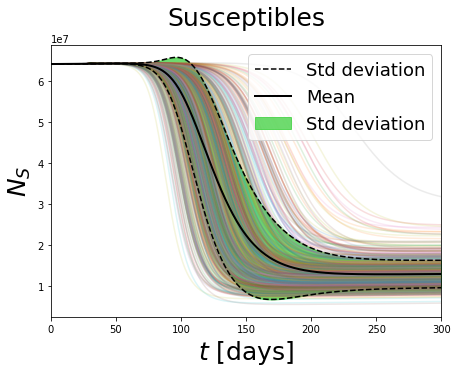

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


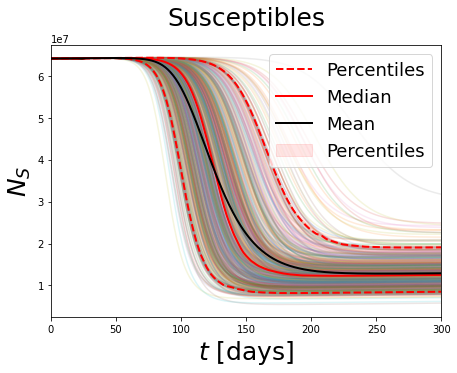

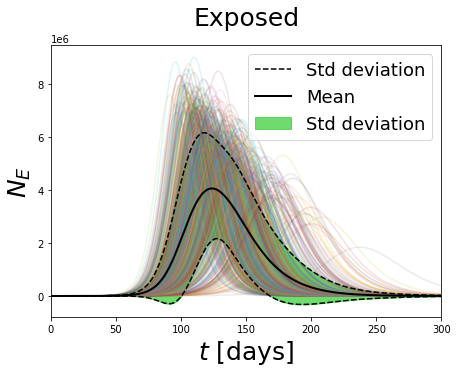

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


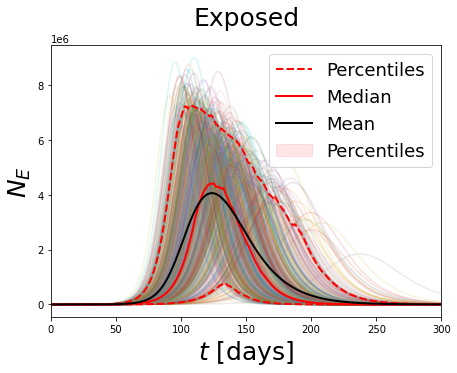

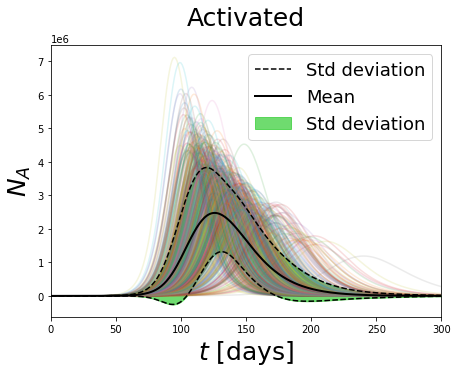

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


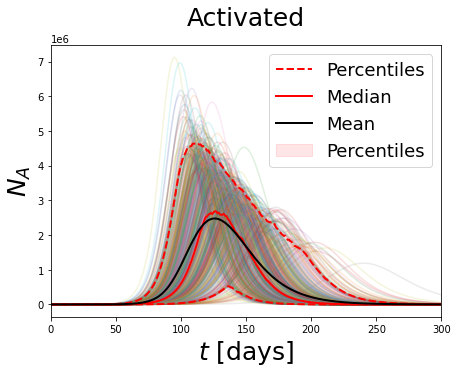

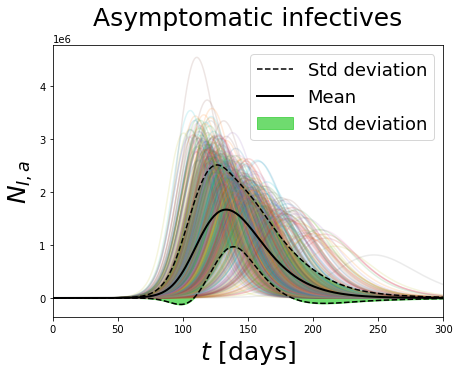

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


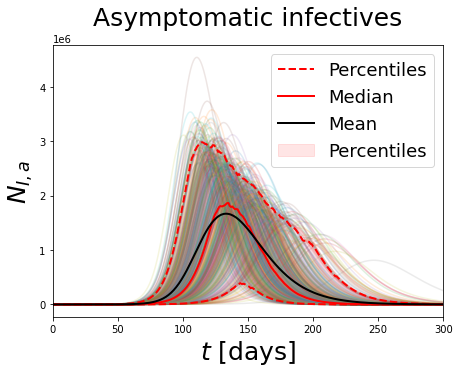

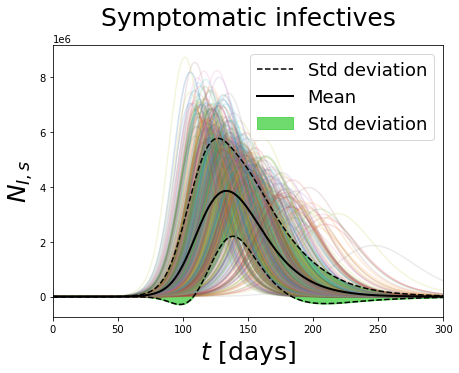

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


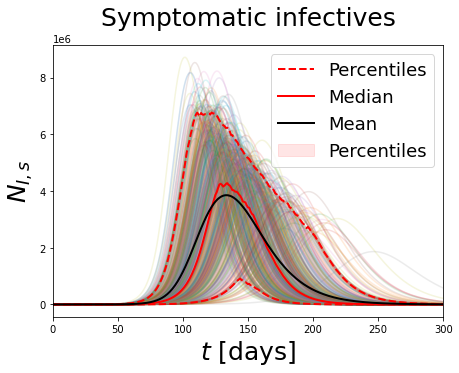

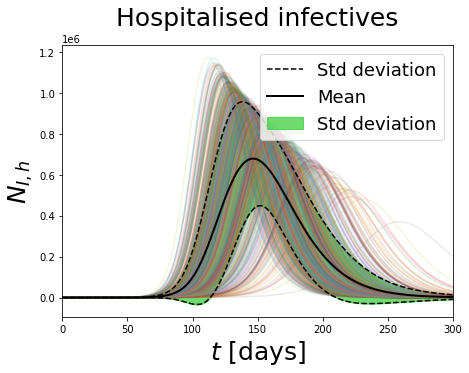

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


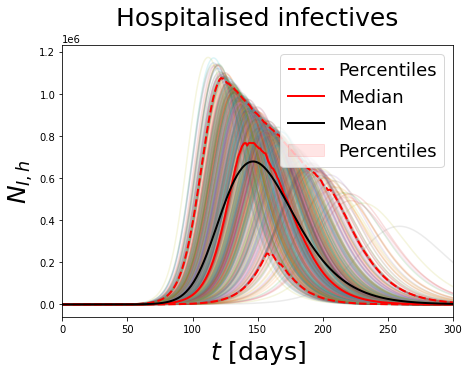

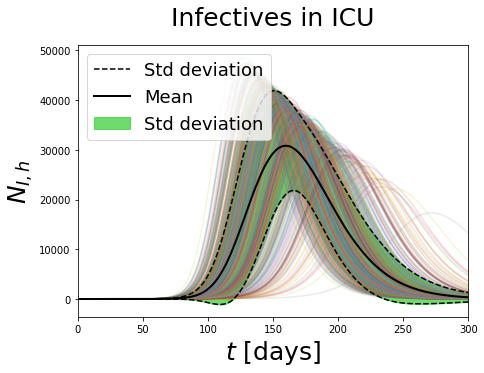

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


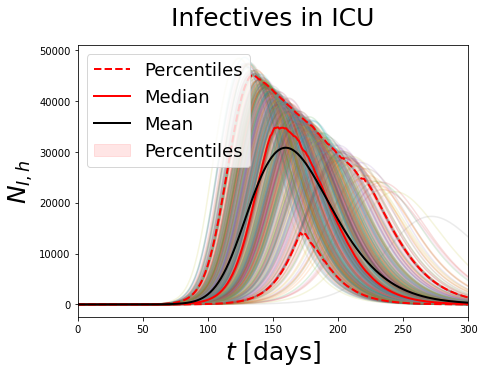

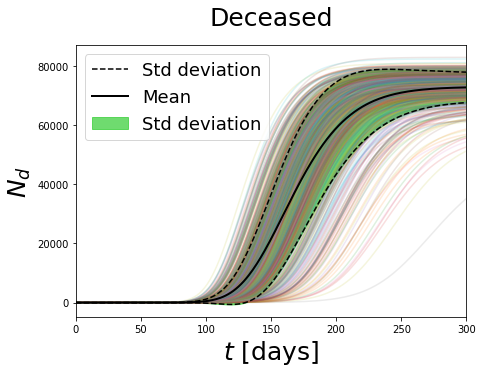

In the following plot, red dashed lines denote 5 and 95 percentiles of the numerical data:


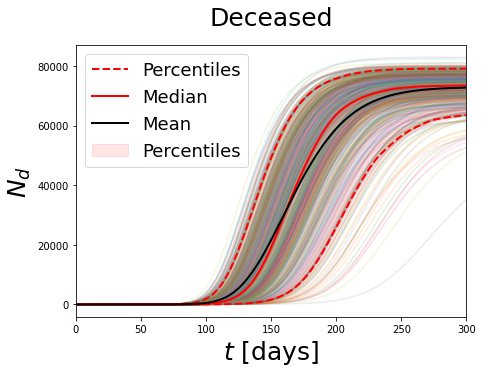

In [8]:
result = model.simulate(S_0, E_0, A_0, Ia_0, Is_0, Ih_0, Ic_0, Im_0,
                                 contactMatrix, Tf, Nf,
                                      verbose=True,
                                     Ns=Ns) 
        
for i in range(8):
    plot_trajectories(result,
                      M=M,
                plot_index = i,
                percentile=5,
               )